In [24]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from sklearn.random_projection import SparseRandomProjection
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [25]:
# --- Configuration ---
DATASET_PATH = r"C:\Users\antma\Downloads\archive\DeepPCB" # Expected path: deeppcb/{train, valid, test}/{images, labels}
# To test with your specific path, uncomment and set the line below:
# DATASET_PATH = r"C:\Users\antma\Downloads\archive\DeepPCB" 
MODEL_BACKBONE = 'resnet18' # Backbone for feature extraction
PATCHCORE_DIM = 1024 # Dimension after random projection
CORESET_PERCENTAGE = 0.1 # Percentage of patches for the coreset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (224, 224) # Resize images to this size (height, width)
BATCH_SIZE = 16 # Adjust based on your GPU memory
NUM_WORKERS = 0 # Set to 0 for easier debugging, especially on Windows. Increase for speed if no issues.

In [26]:
# --- Custom Collate Function ---
def custom_collate_fn(batch):
    """
    Custom collate function to handle batches where some elements (like bounding boxes)
    might have variable lengths.
    """
    # Filter out None items that might occur if __getitem__ returns None on error
    batch = [item for item in batch if item is not None]
    if not batch: # If all items were None or batch is empty
        # Return empty tensors/lists matching the expected structure
        # This structure should match what __getitem__ returns
        return (torch.empty(0, 3, IMG_SIZE[0], IMG_SIZE[1]), # images
                torch.empty(0, dtype=torch.long),            # image_level_labels
                torch.empty(0, 1, IMG_SIZE[0], IMG_SIZE[1]), # gt_binary_masks
                [])                                          # scaled_bboxes_for_viz

    images = torch.stack([item[0] for item in batch], 0)
    image_level_labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    gt_binary_masks = torch.stack([item[2] for item in batch], 0)
    scaled_bboxes_for_viz = [item[3] for item in batch] # Keep as a list of lists of tuples

    return images, image_level_labels, gt_binary_masks, scaled_bboxes_for_viz

In [27]:
# --- 1. DeepPCB Dataset Class ---
class DeepPCBDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, img_size=(224, 224)):
        self.root_dir = root_dir
        self.mode = mode
        self.image_dir = os.path.join(root_dir, mode, 'images')
        self.label_dir = os.path.join(root_dir, mode, 'labels')
        self.transform = transform
        self.img_size_h, self.img_size_w = img_size
        
        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(
                f"Dataset directory not found at {self.image_dir}. "
                f"Please ensure the dataset path '{root_dir}' is correct "
                "and follows the structure: deeppcb/{train, valid, test}/{images, labels}"
            )
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        if not self.image_files:
            print(f"Warning: No .jpg files found in {self.image_dir}")


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        bboxes_original = [] # Bounding boxes in original image coordinates
        image_level_label = 0 # 0 for normal

        try:
            pil_image = Image.open(img_path).convert('RGB')
            original_w, original_h = pil_image.size

            label_name = os.path.splitext(img_name)[0] + '.txt'
            label_path = os.path.join(self.label_dir, label_name)

            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                image_level_label = 1 # 1 for anomaly
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 4: # x_min y_min x_max y_max (class_id is optional)
                            b = [int(p) for p in parts[:4]]
                            bboxes_original.append(b)
            
            transformed_image_tensor = self.transform(pil_image) if self.transform else transforms.ToTensor()(pil_image)

            gt_binary_mask = torch.zeros((self.img_size_h, self.img_size_w), dtype=torch.float32)
            scaled_bboxes_for_viz = [] # This will be a list of tuples
            
            for x_min, y_min, x_max, y_max in bboxes_original:
                scaled_x_min = int((x_min / original_w) * self.img_size_w)
                scaled_y_min = int((y_min / original_h) * self.img_size_h)
                scaled_x_max = int((x_max / original_w) * self.img_size_w)
                scaled_y_max = int((y_max / original_h) * self.img_size_h)

                scaled_bboxes_for_viz.append((scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max))
                
                s_x_min_c = max(0, min(scaled_x_min, self.img_size_w - 1))
                s_y_min_c = max(0, min(scaled_y_min, self.img_size_h - 1))
                s_x_max_c = max(0, min(scaled_x_max, self.img_size_w - 1))
                s_y_max_c = max(0, min(scaled_y_max, self.img_size_h - 1))

                if s_x_max_c > s_x_min_c and s_y_max_c > s_y_min_c:
                    gt_binary_mask[s_y_min_c:s_y_max_c, s_x_min_c:s_x_max_c] = 1.0
            
            return transformed_image_tensor, image_level_label, gt_binary_mask.unsqueeze(0), scaled_bboxes_for_viz

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"ERROR loading item at index {idx}: Image path = {img_path}")
            print(f"Error type: {type(e)}")
            print(f"Error message: {e}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            # Return None, to be filtered by custom_collate_fn
            return None

In [28]:
# --- 2. Feature Extractor ---
def get_feature_extractor(backbone_name):
    if backbone_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
        feature_layers = {'layer2': model.layer2, 'layer3': model.layer3}
    elif backbone_name == 'wide_resnet50_2':
        model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT).to(DEVICE)
        feature_layers = {'layer2': model.layer2, 'layer3': model.layer3}
    else:
        raise NotImplementedError(f"Backbone {backbone_name} not supported.")
    model.eval()
    features_out = {}
    hooks = []
    def get_features_hook(name):
        def hook(module, input, output):
            features_out[name] = output.detach()
        return hook
    for name, layer in feature_layers.items():
        hooks.append(layer.register_forward_hook(get_features_hook(name)))
    return model, features_out, hooks

In [29]:
# --- 3. PatchCore Implementation ---
class PatchCore:
    def __init__(self, backbone_name, dim, coreset_percentage):
        self.model, self.features, self.hooks = get_feature_extractor(backbone_name)
        self.dim = dim
        self.coreset_percentage = coreset_percentage
        self.memory_bank = []
        self.projection = SparseRandomProjection(n_components=self.dim, eps=0.9, random_state=42) 
        self.nn_search = None
        self.metric_data = {} 

    def _extract_patches(self, x):
        self.features.clear() 
        with torch.no_grad():
            _ = self.model(x.to(DEVICE))

        if not self.features: 
            print("Warning: No features captured by hooks.")
            return np.array([]).reshape(0,0), (0,0)

        target_spatial_size = self.features['layer2'].shape[-2:] if 'layer2' in self.features else (1,1)

        layer_features_list = []
        for name, feat_map in self.features.items():
            feat_map_upsampled = torch.nn.functional.interpolate(
                feat_map, size=target_spatial_size, mode='bilinear', align_corners=False
            )
            layer_features_list.append(feat_map_upsampled)

        if not layer_features_list:
             return np.array([]).reshape(0,0), (0,0)

        combined_features = torch.cat(layer_features_list, dim=1)
        B, C, H_feat, W_feat = combined_features.shape
        patches = combined_features.permute(0, 2, 3, 1).reshape(-1, C).cpu().numpy()
        return patches, (H_feat, W_feat)


    def fit(self, train_loader):
        print("Building PatchCore memory bank...")
        all_patches_list = []
        for batch_data in train_loader:
            if not batch_data[0].nelement(): # Check if images tensor is empty after collate
                continue
            images = batch_data[0] 
            
            patches, _ = self._extract_patches(images)
            if patches.size > 0: 
                 all_patches_list.append(patches)

        if not all_patches_list:
            print("Error: No patches extracted during training. Check dataset or feature extraction.")
            self.memory_bank = np.array([]) 
            return 

        all_patches_np = np.concatenate(all_patches_list, axis=0)
        print(f"Extracted {all_patches_np.shape[0]} patches.")

        if all_patches_np.shape[0] == 0:
            print("Error: Concatenated patches are empty.")
            self.memory_bank = np.array([])
            return

        print("Applying random projection...")
        projected_patches = self.projection.fit_transform(all_patches_np)
        
        n_coreset = int(len(projected_patches) * self.coreset_percentage)
        if n_coreset == 0 and len(projected_patches) > 0 : n_coreset = 1 
        
        print(f"Selecting {n_coreset} patches for coreset from {len(projected_patches)} projected patches.")
        if n_coreset > 0 and n_coreset <= len(projected_patches):
             indices = np.random.choice(len(projected_patches), n_coreset, replace=False)
             self.memory_bank = projected_patches[indices]
        elif len(projected_patches) > 0:
            self.memory_bank = projected_patches 
        else:
            print("Warning: No projected patches to form a coreset.")
            self.memory_bank = np.array([]) 
            
        print(f"Coreset size: {self.memory_bank.shape}")

        if self.memory_bank.shape[0] > 0:
            print("Building Nearest Neighbors index...")
            self.nn_search = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='minkowski', p=2)
            self.nn_search.fit(self.memory_bank)
        else:
            print("Warning: Memory bank is empty. Cannot build NN index.")
        print("PatchCore training complete.")

    def predict(self, test_loader):
        print("Performing anomaly detection...")
        prediction_results = [] 
        all_img_gt_labels_list = []
        all_img_pred_scores_list = []
        all_pixel_gt_masks_list = []
        all_pixel_pred_maps_list = []

        if self.nn_search is None or self.memory_bank.shape[0] == 0:
            print("Error: PatchCore not fitted or memory bank is empty. Cannot predict.")
            self.metric_data = {
                "img_gt_labels": np.array([]), "img_pred_scores": np.array([]),
                "pixel_gt_masks": np.array([]), "pixel_pred_maps": np.array([])
            }
            return prediction_results

        with torch.no_grad():
            for images, image_level_labels, gt_binary_masks, gt_bboxes_batch_list in test_loader:
                if not images.nelement(): continue # Skip if batch is empty after collate
                
                patches, (H_feat, W_feat) = self._extract_patches(images)
                if patches.size == 0: continue 

                projected_patches = self.projection.transform(patches)
                distances, _ = self.nn_search.kneighbors(projected_patches)
                
                B = images.shape[0]
                anomaly_maps_batch_raw = distances.reshape(B, H_feat, W_feat)

                for i in range(B):
                    anomaly_map_raw_single = anomaly_maps_batch_raw[i]
                    anomaly_map_smooth = gaussian_filter(anomaly_map_raw_single, sigma=4)
                    anomaly_map_resized = cv2.resize(anomaly_map_smooth, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_LINEAR)

                    img_tensor = images[i].cpu()
                    gt_img_label = image_level_labels[i].item()
                    gt_mask_tensor = gt_binary_masks[i].cpu() 
                    # gt_bboxes_batch_list is the direct output from collate_fn for bboxes
                    # It's a list of lists of tuples. gt_bboxes_batch_list[i] is the list of bboxes for the i-th image.
                    gt_bboxes_for_current_image = gt_bboxes_batch_list[i] 

                    img_score = np.max(anomaly_map_resized) if anomaly_map_resized.size > 0 else 0.0

                    prediction_results.append((img_tensor, gt_img_label, img_score, anomaly_map_resized, gt_mask_tensor, gt_bboxes_for_current_image))
                    
                    all_img_gt_labels_list.append(gt_img_label)
                    all_img_pred_scores_list.append(img_score)
                    all_pixel_gt_masks_list.append(gt_mask_tensor.numpy().flatten()) 
                    all_pixel_pred_maps_list.append(anomaly_map_resized.flatten())

        self.metric_data["img_gt_labels"] = np.array(all_img_gt_labels_list)
        self.metric_data["img_pred_scores"] = np.array(all_img_pred_scores_list)
        if all_pixel_gt_masks_list: 
            self.metric_data["pixel_gt_masks"] = np.concatenate(all_pixel_gt_masks_list)
            self.metric_data["pixel_pred_maps"] = np.concatenate(all_pixel_pred_maps_list)
        else:
            self.metric_data["pixel_gt_masks"] = np.array([])
            self.metric_data["pixel_pred_maps"] = np.array([])
            
        print("Anomaly detection complete.")
        return prediction_results

    def cleanup(self):
        for hook in self.hooks:
            hook.remove()

In [33]:
# Ensure this import is at the top of your script if not already there for other plots
import matplotlib.pyplot as plt
import numpy as np # For arranging bar chart ticks

# --- 4. Metrics Calculation and Display ---
def calculate_and_display_metrics(patch_core_model):
    print("\n--- Anomaly Detection Metrics ---")
    
    metric_data = patch_core_model.metric_data
    img_gt = metric_data.get("img_gt_labels", np.array([]))
    img_scores = metric_data.get("img_pred_scores", np.array([]))
    pixel_gt = metric_data.get("pixel_gt_masks", np.array([]))
    pixel_scores = metric_data.get("pixel_pred_maps", np.array([]))

    # --- Image-Level Metrics ---
    if img_gt.size > 0 and img_scores.size == img_gt.size and len(np.unique(img_gt)) > 1:
        img_auroc = roc_auc_score(img_gt, img_scores)
        print(f"Image-Level AUROC: {img_auroc:.4f}")
        
        fpr, tpr, thresholds_img = roc_curve(img_gt, img_scores)
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f"Image ROC (area = {img_auroc:.2f})", color='blue')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title('Image-Level ROC'); plt.legend(loc="lower right")
        plt.show()

        optimal_idx_img = np.argmax(tpr - fpr)
        optimal_threshold_img = thresholds_img[optimal_idx_img]
        print(f"Image-Level Optimal Threshold (Youden's J): {optimal_threshold_img:.4f}")

        img_pred_binary = (img_scores >= optimal_threshold_img).astype(int)
        
        img_accuracy = accuracy_score(img_gt, img_pred_binary)
        img_precision = precision_score(img_gt, img_pred_binary, zero_division=0, pos_label=1)
        img_recall = recall_score(img_gt, img_pred_binary, zero_division=0, pos_label=1)
        img_f1 = f1_score(img_gt, img_pred_binary, zero_division=0, pos_label=1)
        
        print(f"Image-Level Accuracy: {img_accuracy:.4f}")
        print(f"Image-Level Precision (for anomaly class): {img_precision:.4f}")
        print(f"Image-Level Recall (for anomaly class): {img_recall:.4f}")
        print(f"Image-Level F1-Score (for anomaly class): {img_f1:.4f}")

        # Bar chart for Image-Level Metrics
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        metric_values = [img_accuracy, img_precision, img_recall, img_f1]
        
        plt.figure(figsize=(8, 5))
        bars = plt.bar(metric_names, metric_values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        plt.ylabel('Score')
        plt.title('Image-Level Classification Metrics')
        plt.ylim([0, 1.05])
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')
        plt.show()

    elif img_gt.size > 0:
        print(f"Image-Level Metrics: Not fully calculated. Need at least two classes in ground truth for AUROC and related thresholding. Unique labels: {np.unique(img_gt)}")
    else:
        print("Image-Level Metrics: No data available.")

    # --- Pixel-Level Metrics ---
    if pixel_gt.size > 0 and pixel_scores.size == pixel_gt.size and len(np.unique(pixel_gt)) > 1:
        pixel_auroc = roc_auc_score(pixel_gt, pixel_scores)
        print(f"\nPixel-Level (Segmentation) AUROC: {pixel_auroc:.4f}")
        
        fpr_px, tpr_px, thresholds_px = roc_curve(pixel_gt, pixel_scores)
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr_px, tpr_px, label=f"Pixel ROC (area = {pixel_auroc:.2f})", color='green')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (Pixel)'); plt.ylabel('True Positive Rate (Pixel)')
        plt.title('Pixel-Level (Segmentation) ROC'); plt.legend(loc="lower right")
        plt.show()

        optimal_idx_px = np.argmax(tpr_px - fpr_px)
        optimal_threshold_px = thresholds_px[optimal_idx_px]
        print(f"Pixel-Level Optimal Threshold (Youden's J): {optimal_threshold_px:.4f}")

        pixel_pred_binary = (pixel_scores >= optimal_threshold_px).astype(int)

        pixel_accuracy = accuracy_score(pixel_gt, pixel_pred_binary)
        pixel_precision = precision_score(pixel_gt, pixel_pred_binary, zero_division=0, pos_label=1)
        pixel_recall = recall_score(pixel_gt, pixel_pred_binary, zero_division=0, pos_label=1)
        pixel_f1 = f1_score(pixel_gt, pixel_pred_binary, zero_division=0, pos_label=1)

        print(f"Pixel-Level Accuracy: {pixel_accuracy:.4f}")
        print(f"Pixel-Level Precision (for anomaly pixels): {pixel_precision:.4f}")
        print(f"Pixel-Level Recall (for anomaly pixels): {pixel_recall:.4f}")
        print(f"Pixel-Level F1-Score (for anomaly pixels): {pixel_f1:.4f}")

        # Bar chart for Pixel-Level Metrics
        metric_names_px = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        metric_values_px = [pixel_accuracy, pixel_precision, pixel_recall, pixel_f1]
        
        plt.figure(figsize=(8, 5))
        bars_px = plt.bar(metric_names_px, metric_values_px, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        plt.ylabel('Score')
        plt.title('Pixel-Level Segmentation Metrics')
        plt.ylim([0, 1.05])
        for bar in bars_px:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')
        plt.show()
        
    elif pixel_gt.size > 0:
        print(f"\nPixel-Level Metrics: Not fully calculated. Need at least two classes in ground truth for AUROC and related thresholding. Unique labels: {np.unique(pixel_gt)}")
    else:
        print("\nPixel-Level Metrics: No data available for pixel metrics.")

In [34]:
# --- 5. Visualization ---
def visualize_results(results, num_images=5):
    print("Visualizing results...")
    num_to_show = min(num_images, len(results))
    if num_to_show == 0:
        print("No results to visualize.")
        return

    cols = 4 
    plt.figure(figsize=(cols * 3.5, num_to_show * 3.5)) 

    for i in range(num_to_show):
        img_tensor, gt_img_label, img_score, anomaly_map, gt_mask_tensor, gt_bboxes_for_current_image = results[i]

        img_display = img_tensor.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406]); std = np.array([0.229, 0.224, 0.225])
        img_display = np.clip(std * img_display + mean, 0, 1)
        
        ax1 = plt.subplot(num_to_show, cols, i * cols + 1)
        ax1.imshow(img_display)
        ax1.set_title(f"Original (GT: {'Anomaly' if gt_img_label == 1 else 'Normal'})\nScore: {img_score:.2f}", fontsize=9)
        ax1.axis('off')

        ax2 = plt.subplot(num_to_show, cols, i * cols + 2)
        ax2.imshow(img_display)
        for x_min, y_min, x_max, y_max in gt_bboxes_for_current_image: # Use the correctly named variable
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1.5, edgecolor='lime', facecolor='none')
            ax2.add_patch(rect)
        ax2.set_title("Original + GT BBoxes", fontsize=9)
        ax2.axis('off')

        gt_mask_display = gt_mask_tensor.squeeze().numpy() 
        ax3 = plt.subplot(num_to_show, cols, i * cols + 3)
        ax3.imshow(gt_mask_display, cmap='gray', vmin=0, vmax=1)
        ax3.set_title("GT Anomaly Mask", fontsize=9)
        ax3.axis('off')

        ax4 = plt.subplot(num_to_show, cols, i * cols + 4)
        im = ax4.imshow(anomaly_map, cmap='jet')
        ax4.set_title("Predicted Anomaly Map", fontsize=9)
        ax4.axis('off')
        plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04) 

    plt.tight_layout(pad=0.5) 
    plt.show()

Using device: cpu
Loading datasets...
Building PatchCore memory bank...
Extracted 940800 patches.
Applying random projection...


C:\Users\antma\anaconda3\Lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (384 < 1024).The dimensionality of the problem will not be reduced.
  warnings.warn(


Selecting 94080 patches for coreset from 940800 projected patches.
Coreset size: (94080, 1024)
Building Nearest Neighbors index...
PatchCore training complete.
Performing anomaly detection...
Anomaly detection complete.

--- Anomaly Detection Metrics ---
Image-Level Metrics: Not fully calculated. Need at least two classes in ground truth for AUROC and related thresholding. Unique labels: [1]

Pixel-Level (Segmentation) AUROC: 0.6013


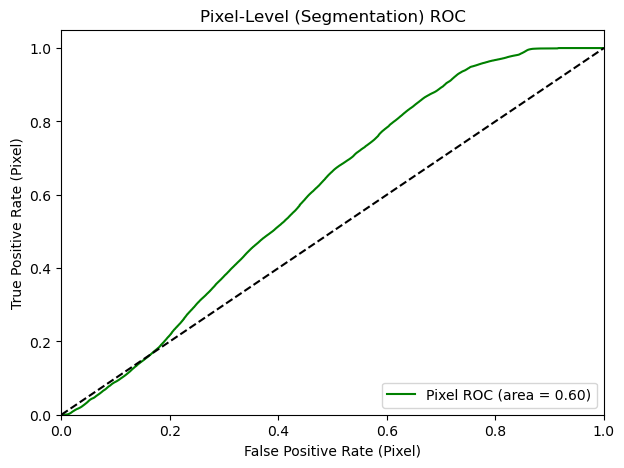

Pixel-Level Optimal Threshold (Youden's J): 2.1155
Pixel-Level Accuracy: 0.2824
Pixel-Level Precision (for anomaly pixels): 0.0279
Pixel-Level Recall (for anomaly pixels): 0.9302
Pixel-Level F1-Score (for anomaly pixels): 0.0542


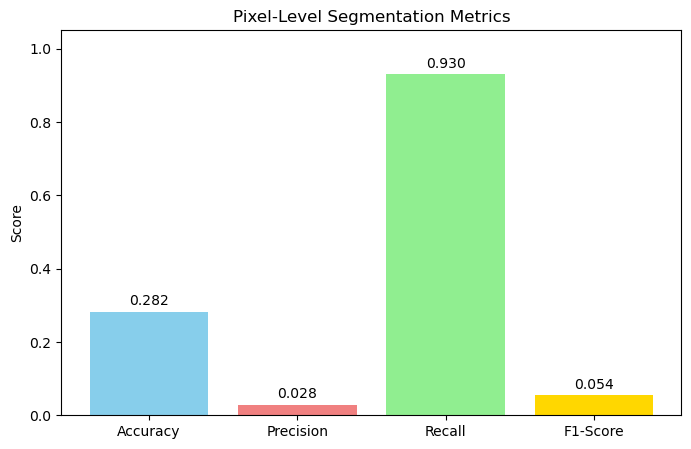

Visualizing results...


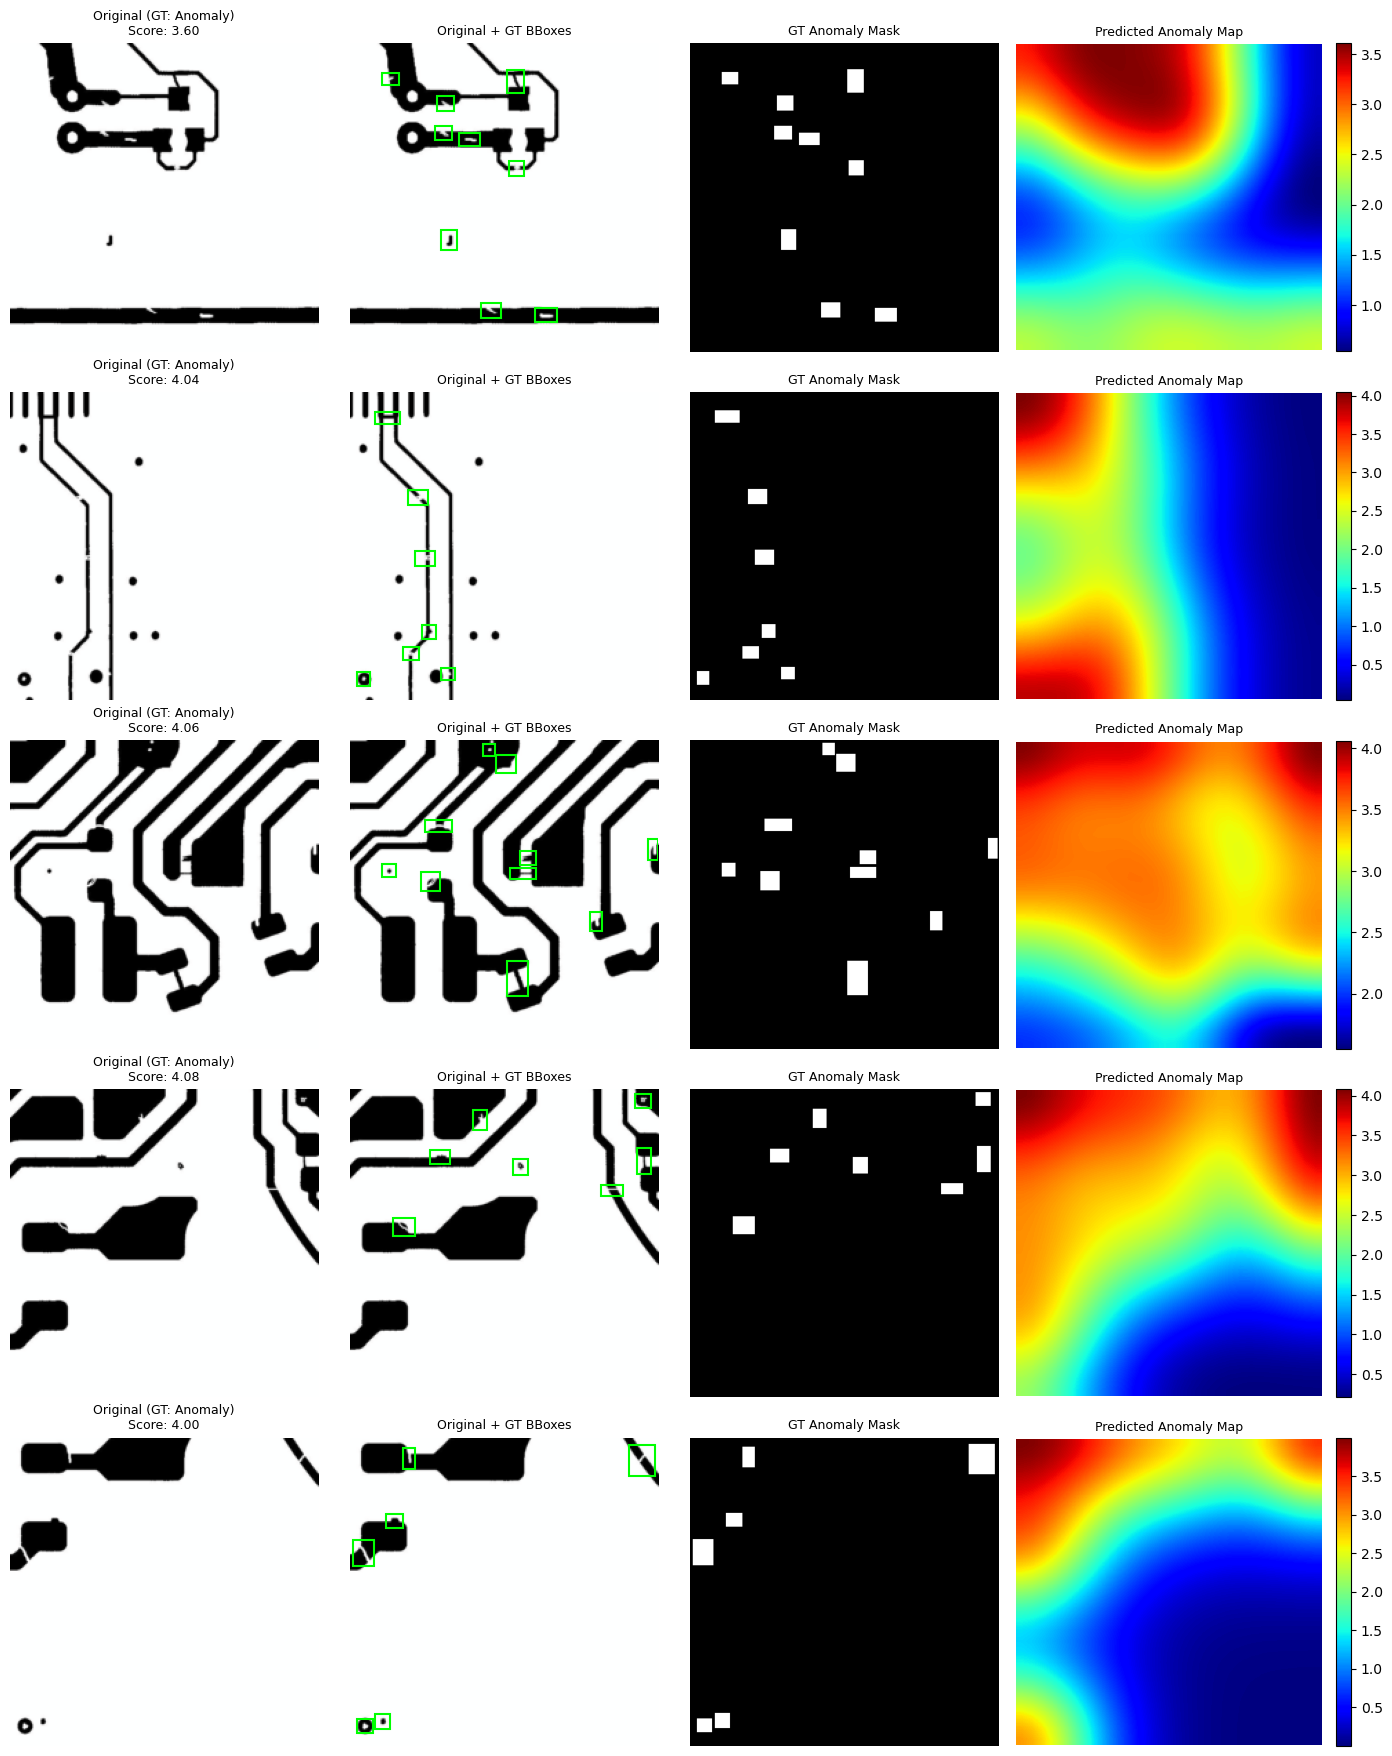

Script finished.


In [35]:
# --- 6. Main Execution ---
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    data_transforms = transforms.Compose([
        transforms.Resize(IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    if not os.path.exists(DATASET_PATH) or not os.path.exists(os.path.join(DATASET_PATH, 'train')):
         print(f"Error: Dataset not found or structured incorrectly at '{DATASET_PATH}'.")
         print("Please download/extract DeepPCB and ensure it has 'train', 'test' folders.")
         print("Expected structure: your_path/deeppcb/{train, test}/{images, labels}")
         exit()

    print("Loading datasets...")
    try:
        train_dataset = DeepPCBDataset(root_dir=DATASET_PATH, mode='train', transform=data_transforms, img_size=IMG_SIZE)
        test_dataset = DeepPCBDataset(root_dir=DATASET_PATH, mode='test', transform=data_transforms, img_size=IMG_SIZE)
    except FileNotFoundError as e:
        print(e)
        exit()

    if len(train_dataset) == 0:
        print(f"Error: No images found in the training set: {os.path.join(DATASET_PATH, 'train', 'images')}")
        exit()
    if len(test_dataset) == 0:
        print(f"Error: No images found in the test set: {os.path.join(DATASET_PATH, 'test', 'images')}")
        exit()

    # Use the custom collate function in DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=NUM_WORKERS, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                             num_workers=NUM_WORKERS, collate_fn=custom_collate_fn)
    
    if len(train_loader) == 0 or len(test_loader) == 0: 
        # This check might be misleading if collate_fn returns empty for all batches
        # due to all items being None. Better to rely on dataset length checks.
        print("Warning: DataLoaders appear empty. This might happen if all items in initial batches failed to load.")
        # Potentially exit if it's a critical issue, but for now, a warning.
        # if len(train_dataset) > 0 and len(test_dataset) > 0:
        #    pass # Datasets have items, so proceed and see if any batches load
        # else:
        #    exit()


    patch_core = PatchCore(backbone_name=MODEL_BACKBONE,
                           dim=PATCHCORE_DIM,
                           coreset_percentage=CORESET_PERCENTAGE)
    patch_core.fit(train_loader)

    prediction_viz_data = patch_core.predict(test_loader)

    calculate_and_display_metrics(patch_core)

    if prediction_viz_data: 
        visualize_results(prediction_viz_data, num_images=5)
    else:
        print("No prediction results to visualize.")

    patch_core.cleanup()
    print("Script finished.")